# Study of Opening Hours of Restaurants

In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import folium
import seaborn

In [2]:
seaborn.set()

In [3]:
# Load the data from the file
data_path = "./opening_hours.json"
data = pd.read_json(data_path, lines = True)

## Overview

### Distribution of Total Hours of Operation in A Week

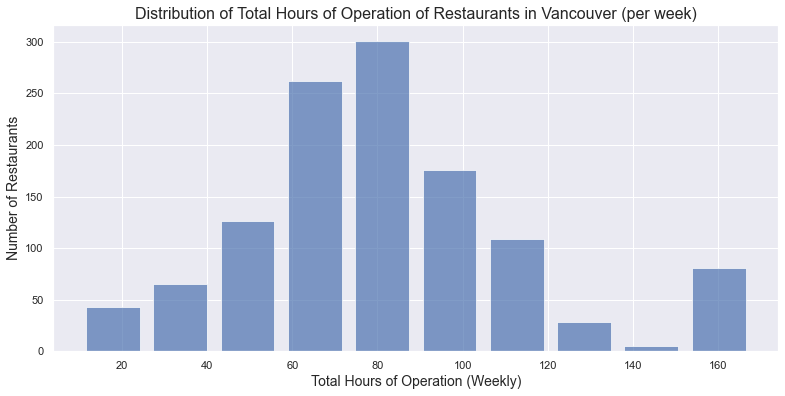

In [4]:
plt.figure(figsize = (13, 6))
plt.hist(
    data['opening_hours_per_week'], 
    rwidth = 0.8, 
    alpha = 0.7
)
plt.title("Distribution of Total Hours of Operation of Restaurants in Vancouver (per week)", fontsize = 16)
plt.xlabel("Total Hours of Operation (Weekly)", fontsize = 14)
plt.ylabel("Number of Restaurants", fontsize = 14)
plt.show()

## Chain Restaurants vs. Non-chain Restaurants

In [5]:
chain = data[data.apply(lambda x: 'brand' in x['tags'], axis = 1)].reset_index(drop = True)
non_chain = data[data.apply(lambda x: 'brand' not in x['tags'], axis = 1)].reset_index(drop = True)

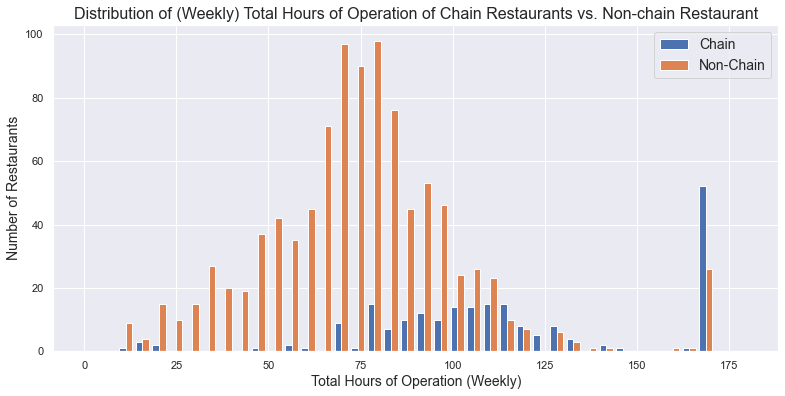

In [6]:
plt.figure(figsize = (13, 6))
plt.hist([
    chain['opening_hours_per_week'], 
    non_chain['opening_hours_per_week']], 
    np.linspace(0, 180, 41)
)
plt.title("Distribution of (Weekly) Total Hours of Operation of Chain Restaurants vs. Non-chain Restaurant", fontsize = 16)
plt.xlabel("Total Hours of Operation (Weekly)", fontsize = 14)
plt.ylabel("Number of Restaurants", fontsize = 14)
plt.legend(["Chain", "Non-Chain"], fontsize = 14)
plt.show()

### Statistical Tests

#### Do chain restaurants have a longer opening hours?

In [7]:
data_x, data_y = chain['opening_hours_per_week'], non_chain['opening_hours_per_week']

In [8]:
# Are they normally distributed
print("Fast food restaurants data normality test p-value:\t", stats.normaltest(data_x).pvalue)
print("Non fast food restaurants data normality test p-value:\t", stats.normaltest(data_y).pvalue)

Fast food restaurants data normality test p-value:	 0.7362092816992584
Non fast food restaurants data normality test p-value:	 9.557252554652752e-29


In [9]:
# Do they have equal variance?
print("Equal-variance test p-value:", stats.levene(data_x, data_y).pvalue)

Equal-variance test p-value: 1.2136306280197282e-09


In [10]:
# Since we have enough data points, we may perform a T-test in this case, 
# even though one of the groups failed the normality test
# Perform a T-test
print("T-test p-value:", stats.ttest_ind(data_x, data_y, equal_var = False).pvalue)

T-test p-value: 9.725496243215882e-37


In [11]:
# p-value for U-test
print("U-test p-value", stats.mannwhitneyu(data_x, data_y).pvalue)

U-test p-value 5.612332396547124e-52


## Analysis For Each Day in A Week

### Distribution of Hours of Operation Each Day in A Week

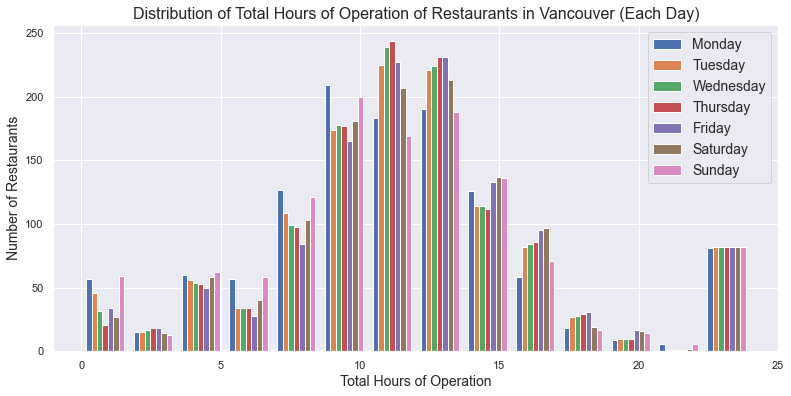

In [12]:
day_of_week_abbr = ["Mo", "Tu", "We", "Th", "Fr", "Sa", "Su"]
day_of_week = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
opening_hours = pd.DataFrame(data['opening_hours'].to_dict()).transpose()
opening_hours
plt.figure(figsize = (13, 6))
plt.hist(
    [opening_hours[key] for key in day_of_week_abbr], 
    np.linspace(0, 24, 15)
)
plt.title("Distribution of Total Hours of Operation of Restaurants in Vancouver (Each Day)", fontsize = 16)
plt.xlabel("Total Hours of Operation", fontsize = 14)
plt.ylabel("Number of Restaurants", fontsize = 14)
plt.legend(day_of_week, fontsize = 14)
plt.show()

### ANOVA Test And Post Hoc Analysis

In [13]:
anova = stats.f_oneway(
    opening_hours["Mo"], 
    opening_hours["Tu"], 
    opening_hours["We"], 
    opening_hours["Th"], 
    opening_hours["Fr"], 
    opening_hours["Sa"], 
    opening_hours["Su"], 
)
print("Anova test p-value:", anova.pvalue)

Anova test p-value: 1.2642792798984302e-05


In [14]:
opening_hours_melt = pd.melt(opening_hours)
posthoc = pairwise_tukeyhsd(
    opening_hours_melt['value'], 
    opening_hours_melt['variable'], 
    alpha = 0.05
)

In [15]:
print(posthoc)

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
    Fr     Mo  -0.8999  0.001 -1.5102 -0.2896   True
    Fr     Sa  -0.1426    0.9 -0.7528  0.4677  False
    Fr     Su  -0.7652 0.0041 -1.3755  -0.155   True
    Fr     Th  -0.1311    0.9 -0.7413  0.4792  False
    Fr     Tu  -0.4304 0.3658 -1.0407  0.1799  False
    Fr     We  -0.2577 0.8671  -0.868  0.3525  False
    Mo     Sa   0.7573 0.0047   0.147  1.3676   True
    Mo     Su   0.1346    0.9 -0.4756  0.7449  False
    Mo     Th   0.7688 0.0039  0.1585  1.3791   True
    Mo     Tu   0.4695 0.2594 -0.1408  1.0798  False
    Mo     We   0.6421 0.0316  0.0319  1.2524   True
    Sa     Su  -0.6227  0.042  -1.233 -0.0124   True
    Sa     Th   0.0115    0.9 -0.5988  0.6218  False
    Sa     Tu  -0.2878 0.7816 -0.8981  0.3224  False
    Sa     We  -0.1152    0.9 -0.7255  0.4951  False
    Su     Th   0.6342 0.0356  0.0239  1.2445 

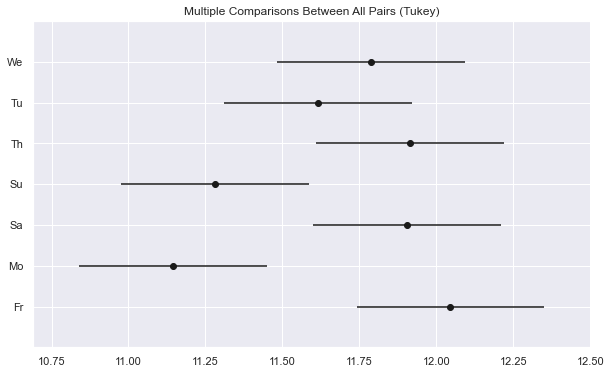

In [16]:
fig = posthoc.plot_simultaneous()

**Conclusion:** If you are planning a tour of the city, based on the above results, Friday would be a better choice. Since in general, most of the restaurants will have a longer opening hour on Friday.